# Scaling Quality Loss

__Imports__

In [18]:
from os import listdir
from os.path import join

import cv2
import numpy as np
from tqdm import tqdm
from scipy.ndimage import imread
from imageutils import imshow
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

__Constants__

In [3]:
TRAIN_PATH       = join('..', 'data', 'raw', 'train')
TRAIN_MASKS_PATH = join(TRAIN_PATH, 'masks')
MASK_EXT         = 'gif'

In [4]:
masks = {f[:-9] : join(TRAIN_MASKS_PATH, f) for f in listdir(TRAIN_MASKS_PATH) if f.endswith("gif")}

In [5]:
def dice_coef(A, B):
    y_true_f = A.flatten()
    y_pred_f = B.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [6]:
image_rows = 1280
image_cols = 1918
smooth = 1.

In [9]:
dest_rows , dest_cols = (248, 384)
interpolation = cv2.INTER_LINEAR

In [10]:
dice = []
for name, mask_path in tqdm(masks.items()):
    mask = imread(mask_path, mode='L')
    
    downscaled = cv2.resize(mask, None, fx=dest_cols/image_cols, fy=dest_rows/image_rows, interpolation = cv2.INTER_AREA)
    
    downscaled[downscaled <= 127] = 0
    downscaled[downscaled > 127]  = 255
        
    rescaled   = cv2.resize(downscaled, None, fx=image_cols/dest_cols, fy=image_rows/dest_rows, interpolation = interpolation)
    
    rescaled[rescaled <= 127] = 0
    rescaled[rescaled  > 127] = 1
    mask[mask <= 127] = 0
    mask[mask  > 127] = 1
    
    dice.append(dice_coef(mask, rescaled))
print('%.5f'% np.average(dice))

100%|██████████| 5088/5088 [04:23<00:00, 20.08it/s]

0.99649


__Resolution, Interpolation = Dice Coef__
* 100px 100px = 0.98998
* 128px 128px = 0.99215
* 128px 192px = 0.99314
* 160px 240px = 0.99451
* 200px 200px = 0.99491
* 248px 248px = 0.99589
* 256px 384px = 0.99589
* 256px 256px = 0.99604
* 300px 300px = 0.99659
* 320px 480px = 0.99728
* 512px 512px = 0.99801
* 640px 959px = 0.99842
* 960px 1439px = 0.99928
* 1280px 1918px = 1.0

In [14]:
data = [
    [100, 100, 0.98998],
    [128, 128, 0.99215],
    [128, 192, 0.99314],
    [160, 240, 0.99451],
    [200, 200, 0.99491],
    [248, 248, 0.99589],
    [256, 256, 0.99604],
    [256, 384, 0.99649],
    [300, 300, 0.99659],
    [320, 480, 0.99728],
    [512, 512, 0.99801],
    [640, 959, 0.99842],
    [960, 1439, 0.99928],
    [1280, 1918, 1.0]
]

In [15]:
df = pd.DataFrame(data=data, columns=['width', 'height', 'dice_coef'])

In [22]:
df

width  height  dice_coef     area
0     100     100    0.98998    10000
1     128     128    0.99215    16384
2     128     192    0.99314    24576
3     160     240    0.99451    38400
4     200     200    0.99491    40000
5     248     248    0.99589    61504
6     256     256    0.99604    65536
7     256     384    0.99649    98304
8     300     300    0.99659    90000
9     320     480    0.99728   153600
10    512     512    0.99801   262144
11    640     959    0.99842   613760
12    960    1439    0.99928  1381440
13   1280    1918    1.00000  2455040

In [20]:
df['area'] = df.width * df.height

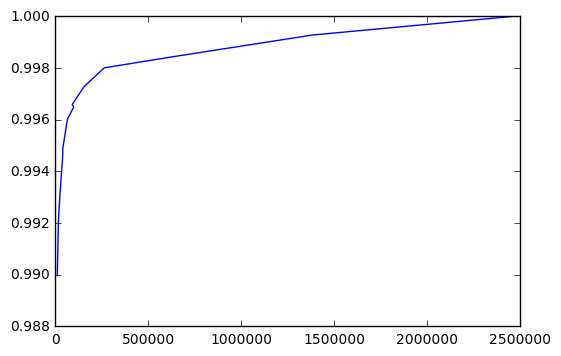

In [26]:
plt.plot(df.area, df.dice_coef)